In [1]:
import pandas as pd
import numpy as np
import pickle
import time
from pandarallel import pandarallel
from tqdm import tqdm
from scipy.stats import hypergeom
import collections
from collections import defaultdict
import re
pandarallel.initialize(progress_bar = True)
tqdm.pandas()
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt
import joblib
import matplotlib
import itertools
from random import sample
from itertools import compress
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.size'] = 15
#visualize all the columns in pandas-->BIG TABLES
pd.set_option('display.max_columns', None)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [4]:
pathdir='./input_data/'

# Exposure Module Colormap

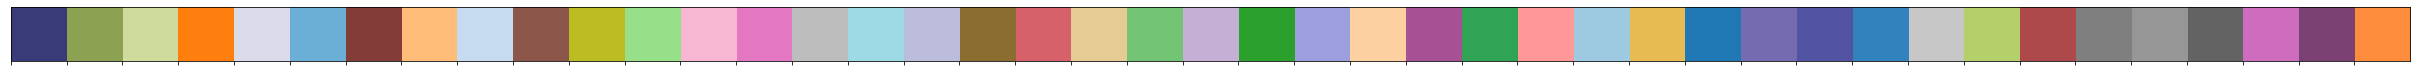

In [5]:
selcolorC=joblib.load(pathdir+'colormapmodulesexposome.pkl')
(macrocat, var2cat)=joblib.load(pathdir+'exposome_modules.pkl')
# all colors
sns.palplot(selcolorC)

# Load Regression Data

To select the most robust signal, we studied only variables measured in at least two cycles of NHANES. To quantify the statistical associations, we employed the Survey-weighted Generalized Linear Model, and in particular, linear regression to predict continuous variables, and logistic regression for categorical. All models were adjusted for age, sex, ethnicity, Body Mass Index (BMI), total-caloric intake, and estimated Socioeconomic Status (SES), as provided by NHANES. We employed the "survey" statistical package in R to account for the complex survey design of NHANES. We further filtered all categorical and continuous variables lacking a minimum sample size to perform regression analysis. In particular, for continuous variables we considered a ratio between number of covariates and number of data points $\le$ 1/50, while for categorical we applied a similar threshold for the ratio between  number of covariates and number of data points in the smallest category (variable 'ratiocovdatapoints').
On the exposure panel surviving these criteria we apply FDR BH correction ( variables 'h', 'adj_p')

In [6]:
# files from regression + FDR BH
WCDPIt= pd.read_csv(pathdir+'reg_ens_WCDPI.csv')
RWWFDPIt= pd.read_csv(pathdir+'reg_ens_WFDPIRW.csv')

# manual NOVA 4
manualNOVA4t= pd.read_csv(pathdir+'reg_manualNOVA4.csv')

var2descr={x: y for (x,y) in WCDPIt[['var', 'var_desc']].values}

In [7]:
#colormap (select the number of colormaps according to the number of the exposures)
cmapdictC={k:c for (k,c) in zip(macrocat,selcolorC)}
# var to color
var2color={k:cmapdictC[v] for (k,v) in var2cat.items()}
print('Number of colors selected: ', len(cmapdictC))

Number of colors selected:  43


# Merge Data

In [8]:
# union all the labels 

tsIHW=0.05
varMT='adj_p'

dictsignificantvar={'FPro WC': set(WCDPIt[WCDPIt[varMT]<=tsIHW]['var']),
                    'FPro WG': set(RWWFDPIt[RWWFDPIt[varMT]<=tsIHW]['var']),
                   'manual NOVA 4':  set(manualNOVA4t[manualNOVA4t[varMT]<=tsIHW]['var'])}

RW_Cal=(dictsignificantvar['FPro WC']|dictsignificantvar['FPro WG'])
print('Number of Significant Exposures from FPro WC and FPro WG:', len(RW_Cal))

RW_Cal_NOVA4=(dictsignificantvar['FPro WC']|dictsignificantvar['FPro WG']|dictsignificantvar['manual NOVA 4'])
print('Number of Significant Exposures from FPro WC, FPro WG, and NOVA4 manual:', len(RW_Cal_NOVA4))

Number of Significant Exposures from FPro WC and FPro WG: 209
Number of Significant Exposures from FPro WC, FPro WG, and NOVA4 manual: 214


# Venn Diagram

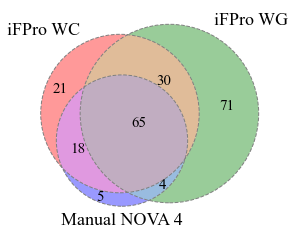

In [9]:
a=len(dictsignificantvar['FPro WC']-(dictsignificantvar['FPro WG']|dictsignificantvar['manual NOVA 4']))
b=len(dictsignificantvar['FPro WG']-(dictsignificantvar['FPro WC']|dictsignificantvar['manual NOVA 4']))
c=len((dictsignificantvar['FPro WC']&dictsignificantvar['FPro WG'])-dictsignificantvar['manual NOVA 4'])
d=len(dictsignificantvar['manual NOVA 4']-(dictsignificantvar['FPro WG']|dictsignificantvar['FPro WC']))
e=len((dictsignificantvar['FPro WC']&dictsignificantvar['manual NOVA 4'])-dictsignificantvar['FPro WG'])
f=len((dictsignificantvar['FPro WG']&dictsignificantvar['manual NOVA 4'])-dictsignificantvar['FPro WC'])
g=len((dictsignificantvar['FPro WC']&dictsignificantvar['manual NOVA 4']&dictsignificantvar['FPro WG']))

v=venn3(subsets = (a, b, c, d,e,f,g), set_labels = ('iFPro WC', 'iFPro WG', 'Manual NOVA 4'))
cc=venn3_circles(subsets = (a, b, c, d,e,f,g), linestyle='dashed', linewidth=1, color="grey")

# Summary Panel for Comparison

In [10]:
cols=['Exposure_Full', 'var_name','bRWWFDPI', 'bWCDPI', 'bN4']
listseries=[RWWFDPIt['var_desc'][RWWFDPIt['var'].isin(RW_Cal_NOVA4)],
     RWWFDPIt['var'][RWWFDPIt['var'].isin(RW_Cal_NOVA4)],
     RWWFDPIt['coef'][RWWFDPIt['var'].isin(RW_Cal_NOVA4)], 
     WCDPIt['coef'][WCDPIt['var'].isin(RW_Cal_NOVA4)],
     manualNOVA4t['coef'][manualNOVA4t['var'].isin(RW_Cal_NOVA4)]]

df = pd.DataFrame(listseries)
df=df.transpose()
df.columns=cols

df['bRWWFDPIpvalue']=RWWFDPIt['pvalue'][RWWFDPIt['var'].isin(RW_Cal_NOVA4)]   
df['bWCDPIpvalue']=WCDPIt['pvalue'][WCDPIt['var'].isin(RW_Cal_NOVA4)]  
df['bN4pvalue']=manualNOVA4t['pvalue'][manualNOVA4t['var'].isin(RW_Cal_NOVA4)]   

df['bRWWFDPIp_adj']=RWWFDPIt['adj_p'][RWWFDPIt['var'].isin(RW_Cal_NOVA4)]   
df['bWCDPIp_adj']=WCDPIt['adj_p'][WCDPIt['var'].isin(RW_Cal_NOVA4)]  
df['bN4p_adj']=manualNOVA4t['adj_p'][manualNOVA4t['var'].isin(RW_Cal_NOVA4)]     
                           
df=df.set_index('Exposure_Full')
df.loc[:,'bRWWFDPI':'bN4']=df.loc[:,'bRWWFDPI':'bN4'].astype('float')
df.loc[:,'bRWWFDPIpvalue':'bN4pvalue']=df.loc[:,'bRWWFDPIpvalue':'bN4pvalue'].astype('float')
df.loc[:,'bRWWFDPIp_adj':'bN4p_adj']=df.loc[:,'bRWWFDPIp_adj':'bN4p_adj'].astype('float')

df['category']=[var2cat[x] for x in df['var_name']]
df['color']=[var2color[x] for x in df['var_name']]

df=df.sort_values(by=['category', 'var_name'])
row_colors=list(df['color'])

In [11]:
def NumSignifTests(x):
    d = {}
    d['NumTests_WG']=sum(x['bRWWFDPIp_adj']<=tsIHW)
    d['NumTests_WC']=sum(x['bWCDPIp_adj']<=tsIHW)
    d['NumTests_manualNOVA4']=sum(x['bN4p_adj']<=tsIHW)
    
    return pd.Series(d, index=['NumTests_WG', 'NumTests_WC', 'NumTests_manualNOVA4'])

modulecount=df.groupby('category').apply(NumSignifTests)
modulecount

,NumTests_WG,NumTests_WC,NumTests_manualNOVA4
category,,,
acrylamide,1,2,2
aging,1,1,0
biochemistry,30,25,22
blood,6,7,4
blood pressure,3,1,0
body measures,12,14,8
cognitive functioning,2,0,0
diakyl,4,5,2
dioxins,4,0,0


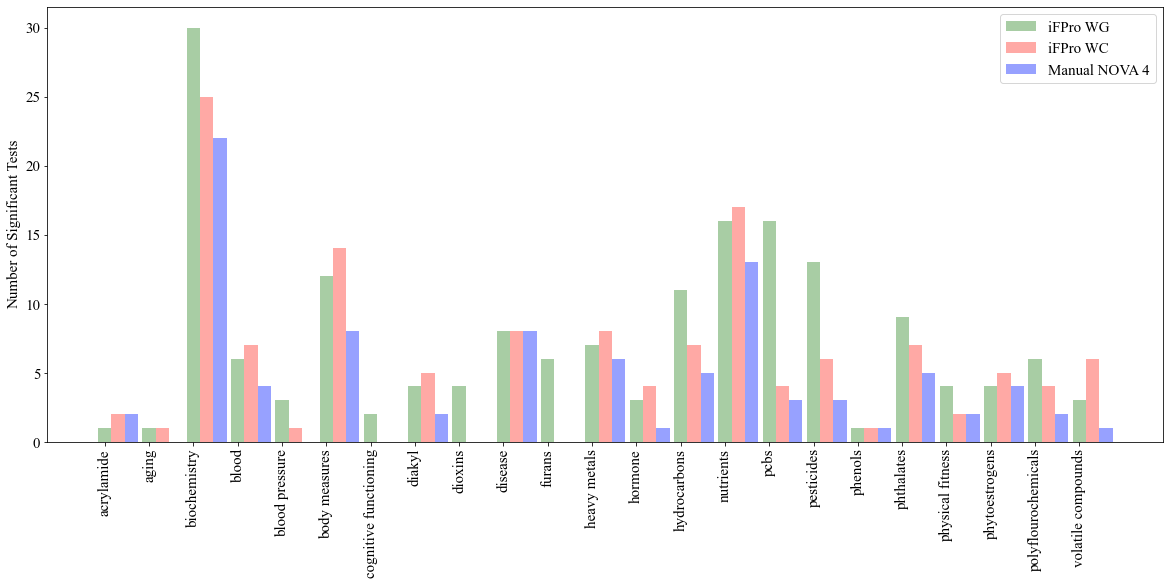

In [12]:
plt.figure(figsize = (20, 8))
width =0.3
plt.bar(np.arange(modulecount.shape[0]), modulecount['NumTests_WG'], width=width, label='iFPro WG', color='#A8CDA4')
plt.bar(np.arange(modulecount.shape[0])+ width, modulecount['NumTests_WC'], width=width, label='iFPro WC', color='#FFA9A5')
plt.bar(np.arange(modulecount.shape[0])+ 2*width, modulecount['NumTests_manualNOVA4'], width=width, label='Manual NOVA 4', color='#97A1FF')
plt.legend()
plt.xlabel('')
plt.ylabel('Number of Significant Tests')
plt.xticks(np.arange(modulecount.shape[0]), modulecount.index, rotation=90);

# Visualization of the Exposure Panels

In [13]:
def describe_coef(row):
    cols = list(row.index)
    
#    R:   0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
#     *** denotes p‐value<0.001; ** denotes p‐value <0.01 but >=0.001; * denotes p‐value <0.05 but>=0.01
    for col in cols:
        p_value = round(row[col], 4)
        
        if row[col] < 0.001:
            row[col + "_s"] = '***' #+ str(p_value)
            
        elif 0.001 <= row[col] < 0.01:
            row[col + "_s"] = '**' #+ str(p_value)
            
        elif 0.01 <= row[col] < 0.05:
            row[col + "_s"] = '*' #+ str(p_value)
            
        elif 0.05 <= row[col] < 0.1:
            row[col + "_s"] = '.'
        else:
            row[col + "_s"] = ''
            
    return row
    pass

# Health Phenotypes

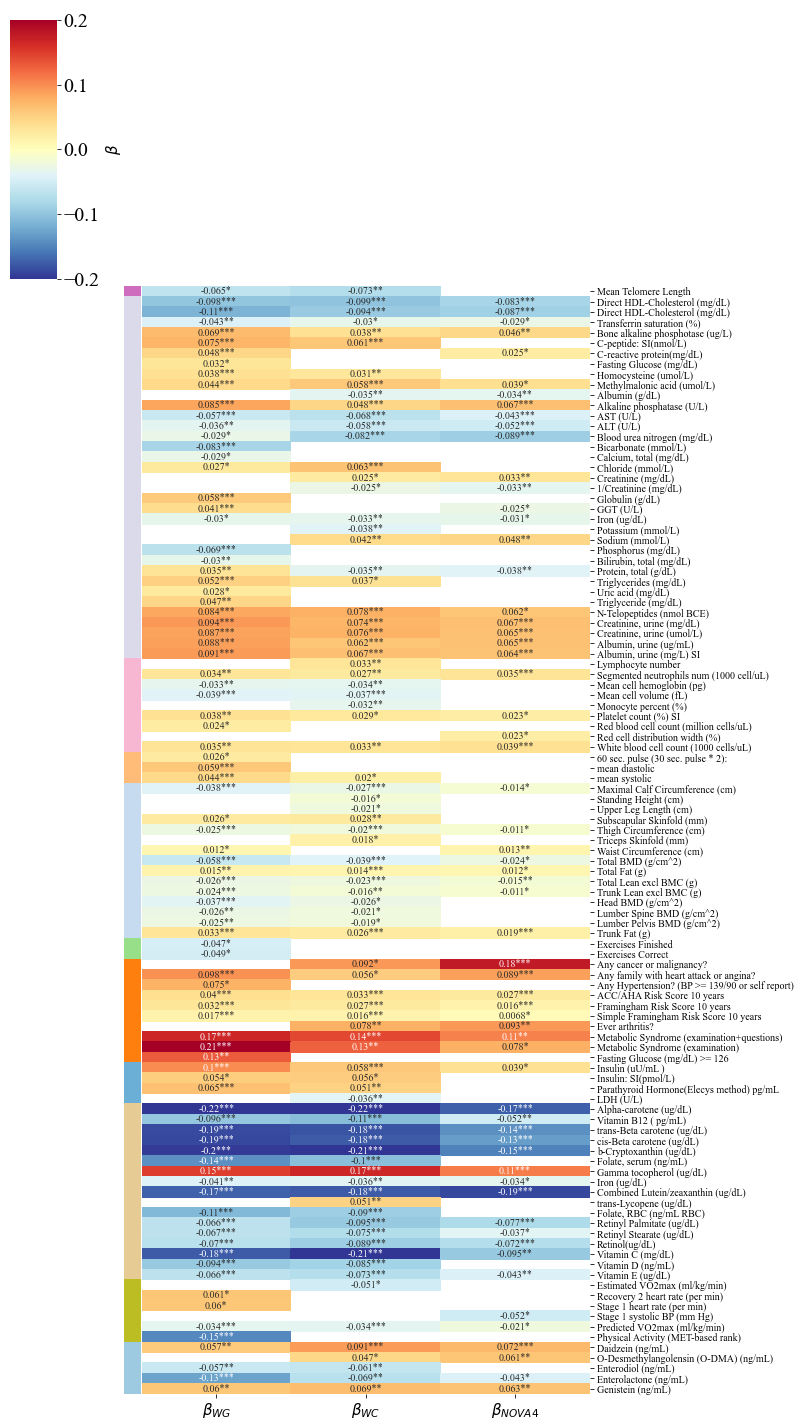

In [14]:
outcomeclass=['aging',
 'biochemistry',
 'blood',
 'blood pressure',
 'body measures',
 'cognitive functioning',
 'disease',
 'hormone',
 'nutrients',
 'physical fitness',
 'phytoestrogens']

tmp = df.loc[df['category'].isin(outcomeclass),'bRWWFDPIp_adj': 'bN4p_adj'].apply(describe_coef, axis=1)
stars = [sig for r in tmp.loc[:, 'bRWWFDPIp_adj_s':'bN4p_adj_s'].values for sig in r if '*' in sig]


g = sns.clustermap(
    df.loc[df['category'].isin(outcomeclass),'bRWWFDPI': 'bN4'], 
    mask=(df.loc[df['category'].isin(outcomeclass),'bRWWFDPIp_adj': 'bN4p_adj']>tsIHW).values,
    figsize=(13,20), cmap="RdYlBu_r",vmin=-0.2,vmax=0.2,center=0,annot=True,
    row_colors=list(compress(row_colors, df['category'].isin(outcomeclass))),
    row_cluster=False, col_cluster=False, annot_kws={"size": 10},yticklabels=1, cbar_kws={'label': r'$\beta$', 'orientation': 'vertical'})

ax = g.ax_heatmap
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)


ax.set_ylabel('');
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10);
ax.set_xticklabels([r'$\beta_{WG}$',r'$\beta_{WC}$',r'$\beta_{NOVA 4}$'], fontsize = 10);
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 15);


if len(stars) != len(ax.axes.texts):
    raise Exception("len(stars) does not match the mask for beta values")

for i in range(len(ax.axes.texts)):
    ax.axes.texts[i]._text += stars[i]

# Chemical Exposures

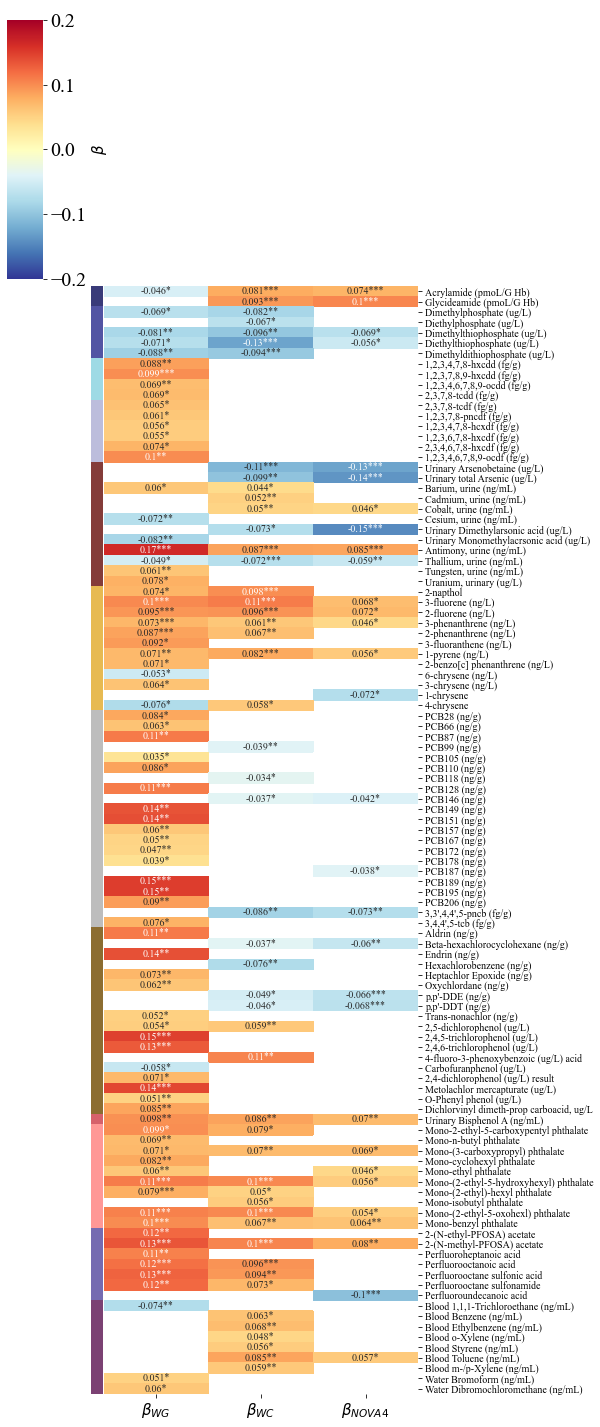

In [15]:
outcomeclass=['acrylamide',
 'diakyl',
 'dioxins',
 'furans',
 'heavy metals',
 'hydrocarbons',
 'pcbs',
 'pesticides',
 'phenols',
 'phthalates',
 'polyflourochemicals',
 'volatile compounds']

tmp = df.loc[df['category'].isin(outcomeclass),'bRWWFDPIp_adj': 'bN4p_adj'].apply(describe_coef, axis=1)
stars = [sig for r in tmp.loc[:, 'bRWWFDPIp_adj_s':'bN4p_adj_s'].values for sig in r if '*' in sig]


g = sns.clustermap(
    df.loc[df['category'].isin(outcomeclass),'bRWWFDPI': 'bN4'], 
    mask=(df.loc[df['category'].isin(outcomeclass),'bRWWFDPIp_adj': 'bN4p_adj']>tsIHW).values,
    figsize=(10,20), cmap="RdYlBu_r",vmin=-0.2,vmax=0.2,center=0,annot=True,
    row_colors=list(compress(row_colors, df['category'].isin(outcomeclass))),
    row_cluster=False, col_cluster=False, annot_kws={"size": 10},yticklabels=1, cbar_kws={'label': r'$\beta$', 'orientation': 'vertical'})

ax = g.ax_heatmap
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)


ax.set_ylabel('');
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10);
ax.set_xticklabels([r'$\beta_{WG}$',r'$\beta_{WC}$', r'$\beta_{NOVA 4}$'], fontsize = 10);
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 15);


if len(stars) != len(ax.axes.texts):
    raise Exception("len(stars) does not match the mask for beta values")

for i in range(len(ax.axes.texts)):
    ax.axes.texts[i]._text += stars[i]